<a href="https://colab.research.google.com/github/hebertgo/Prueba_Data_Science_Davivienda/blob/master/datos_no_estructurados_01_HebertGomez/Prueba_de_conocimientos_II_DNE_Davivienda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Consideraciones Iniciales**

## Instalación de librerías

In [90]:
!pip install -r requirements.txt

## Importaciones

In [91]:
import pandas as pd
import numpy as np
import joblib
import string
import re
import nltk
from nltk.corpus import words, stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from time import time
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
import gensim
from gensim.models import Word2Vec
from collections import Counter
from sklearn.datasets import make_classification
from sentiment_analysis_spanish import sentiment_analysis
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.luhn import LuhnSummarizer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('punkt')

nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Manejo de datos**

In [92]:
file_path = 'tweets/davivienda_tweets.csv'

def split_data(file_path):
    """
    Divide un archivo CSV en 10 partes aproximadamente iguales y guarda cada parte en archivos separados.

    Parámetros:
    file_path (str): El nombre del archivo CSV que se va a dividir.

    Ejemplo de uso:
    split_data(file_path='tweets/davivienda_tweets.csv')
    """
    # Lectura del archivo
    a = pd.read_csv(file_path)
    file_name = file_path.replace('.csv', '')

    # Definir el número de partes para dividir la data
    n_parts = 10

    # Calcular el tamaño de cada parte
    chunk_size = len(a) // n_parts

    # Guardar cada parte en un archivo separado
    for i in range(n_parts):
        start = i * chunk_size
        end = (i + 1) * chunk_size if i != n_parts - 1 else len(a)
        chunk = a.iloc[start:end]
        chunk.to_csv(f'{file_name}{i+1}.csv', index=False)

split_data(file_path=file_path)

## Limpieza de los datos

In [93]:
# Cargar el dataframe
df = pd.read_csv(file_path,sep=',',low_memory=False)

def f_preprocess_df(data):
    """
    Preprocesa el texto para limpieza y normalización.

    Esta función convierte el texto a minúsculas, elimina caracteres especiales,
    URLs, puntuaciones, dígitos, caracteres individuales y espacios múltiples.

    Parámetros:
    data (str): El texto a preprocesar.

    Retorna:
    str: El texto preprocesado.
    """
    text = str(data)  # Convertir todo el texto a cadenas
    text = text.lower()  # Convertir a minúsculas
    text = text.replace('\n', ' ')  # Reemplazar saltos de línea por espacios
    text = text.replace('@', ' ')  # Reemplazar arrobas por espacios
    text = re.sub(r'[^a-zA-Z0-9ñóáíéúy\s]', '', text)  # Eliminar caracteres especiales
    text = re.sub(r'/^[^`!#$%^&()_=+\\;:"\/?>.<,-]$/', ' ', text)  # Eliminar caracteres especiales adicionales
    text = re.sub(r'(http|https)?://\S+|www\.\S+', '', text)  # Eliminar URLs
    text = re.sub(r'[^\w\s]', ' ', text)  # Eliminar puntuación
    text = re.sub(r'[\d]+', ' ', text)  # Eliminar dígitos
    text = re.sub(r'\b\w\b', ' ', text)  # Eliminar caracteres individuales
    text = re.sub(r'\s{2,}', ' ', text)  # Eliminar espacios múltiples
    return text

# Crear una copia del DataFrame original
df_copy = df.copy()

# Aplicar la función de preprocesamiento a la columna 'Embedded_text' en la copia del DataFrame
df_copy["Embedded_text"] = df_copy["Embedded_text"].apply(f_preprocess_df)

# Eliminar las columnas no deseadas
df_copy.drop(columns=['UserScreenName','UserName','Text','Timestamp','Unnamed: 0','Emojis','Comments','Likes','Retweets','Image link','Tweet URL'], inplace=True)

# Mostrar las primeras 15 filas del DataFrame resultante
df_copy.head(15)

,Embedded_text
0,la confianza se afectó el indicador de confian...
1,buscamos la accesibilidad mejor atención en tu...
2,señores davivienda no he podido ingresar mi ap...
3,llevo toda una semana sufriendo intento de hur...
4,hemos retrocedido tanto en este país con este ...
5,open data ceo pregúntele la gente de pie si es...
6,conoce los requisitos de la convocatoria de be...
7,mamado de ser adulto tener que trabajar para p...
8,daviplata ayuda por favor llevo más de meses t...
9,cierto recuerdo en se vendieron empresas como ...


## Procesamiento de Texto: Eliminación de Puntuaciones y Stopwords

In [94]:
# Obtener la lista de stopwords en español
stop=stopwords.words("spanish")

# Añadir la palabra 'si' a la lista de stopwords
stop.append('si')
# Eliminar la palabra 'no' de la lista de stopwords
stop.remove('no')
print("Lista actualizada de stopwords", stop) # Imprimir la lista actualizada de stopwords

def process_text(text):
    """
    Procesa el texto eliminando puntuaciones y stopwords.

    Esta función elimina la puntuación del texto, tokeniza el texto, elimina
    las stopwords y luego une las palabras restantes en una oración.

    Parámetros:
    text (str): El texto a procesar.

    Retorna:
    str: El texto procesado.
    """
    # Eliminar puntuación
    Punctuation = ''.join([char for char in text if char not in string.punctuation])
    # Tokenizar el texto
    Punctuation = nltk.tokenize.word_tokenize(Punctuation)
    # Eliminar stopwords
    clean_words = [word for word in Punctuation if word.lower() not in stop]
    # Unir las palabras restantes en una oración
    sentence = ' '.join(clean_words)
    return sentence
# Aplicar la función de procesamiento a la columna 'Embedded_text'
df_copy['Embedded_text'] = df_copy['Embedded_text'].apply(process_text)


Lista actualizada de stopwords ['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamo

In [95]:
df_copy['Embedded_text'].head()

0    confianza afectó indicador confianza daviviend...
1    buscamos accesibilidad mejor atención trámites...
2    señores davivienda no podido ingresar app davi...
3    llevo toda semana sufriendo intento hurto medi...
4    retrocedido país gobierno malparidos cajeros d...
Name: Embedded_text, dtype: object

# Análisis de Frecuencia de Palabras

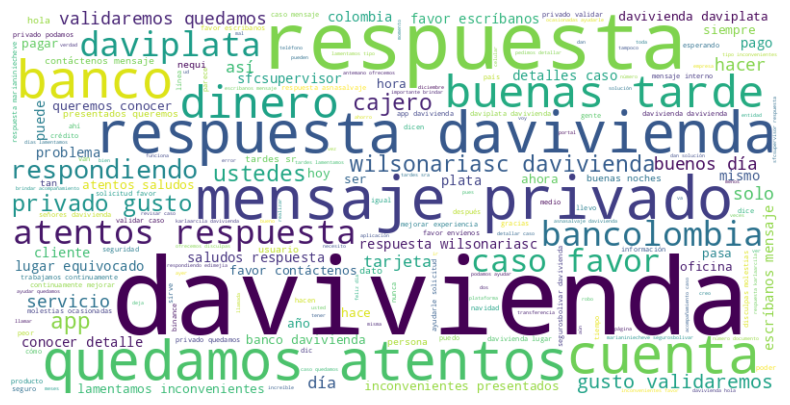

In [96]:


# Importar CountVectorizer para transformar el texto en una matriz de términos
vectorizer = CountVectorizer(max_features=1000)

# Ajustar y transformar los datos de texto en una matriz de características
X = vectorizer.fit_transform(df_copy['Embedded_text'])

# Obtener las frecuencias de las palabras en la matriz de características
frecuencias_palabras = np.asarray(X.sum(axis=0)).flatten()

# Crear un DataFrame con las palabras y sus frecuencias
frecuencia_df = pd.DataFrame({'Palabra': vectorizer.get_feature_names_out(), 'Frecuencia': frecuencias_palabras})

# Ordenar el DataFrame por frecuencia de las palabras en orden descendente
frecuencia_df = frecuencia_df.sort_values(by='Frecuencia', ascending=False)

# Generar una nube de palabras a partir del texto procesado
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_copy['Embedded_text']))

# Visualizar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()




In [97]:

# Inicializar el analizador de sentimientos en español
sentiment = sentiment_analysis.SentimentAnalysisSpanish()

# Aplicar el análisis de sentimientos a la columna 'Embedded_text'
df_copy['Embedded_text_blob'] = df_copy['Embedded_text'].apply(lambda x: sentiment.sentiment(x))

# Mostrar las primeras 5 filas de la columna con el análisis de sentimientos
df_copy['Embedded_text_blob'].head()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


0    0.052709
1    0.895473
2    0.004789
3    0.008526
4    0.053349
Name: Embedded_text_blob, dtype: float64

## Sumarización de Texto usando Luhn Algorithm con Sumy

In [98]:


def summarize_text_sumy(texto, cantidad_oraciones=5):
    """
    Resume el texto de entrada utilizando el algoritmo Luhn.

    Parámetros:
    texto (str): El texto de entrada que se va a resumir.
    cantidad_oraciones (int): Número de oraciones en el resumen (por defecto es 5).

    Retorna:
    str: El texto resumido.
    """
    # Crear un parser de texto plano con el texto de entrada
    parser = PlaintextParser.from_string(texto, Tokenizer("english"))
    # Inicializar el sumarizador Luhn
    summarizer = LuhnSummarizer()
    # Generar el resumen
    summary = summarizer(parser.document, cantidad_oraciones)
    # Combinar las oraciones para formar el texto del resumen
    texto_resumido = ' '.join([str(oracion) for oracion in summary])
    return texto_resumido



In [99]:
# Aplicar la función summarize_text_sumy a la columna 'Embedded_text' y crear una nueva columna 'Embedded_text_Sumy'
df_copy['Embedded_text_Sumy'] = df_copy['Embedded_text'].apply(lambda x: summarize_text_sumy(x))

# Mostrar las primeras filas del DataFrame df_copy para verificar los resultados
df_copy

,Embedded_text,Embedded_text_blob,Embedded_text_Sumy
0,confianza afectó indicador confianza daviviend...,0.052709,confianza afectó indicador confianza daviviend...
1,buscamos accesibilidad mejor atención trámites...,0.895473,buscamos accesibilidad mejor atención trámites...
2,señores davivienda no podido ingresar app davi...,0.004789,señores davivienda no podido ingresar app davi...
3,llevo toda semana sufriendo intento hurto medi...,0.008526,llevo toda semana sufriendo intento hurto medi...
4,retrocedido país gobierno malparidos cajeros d...,0.053349,retrocedido país gobierno malparidos cajeros d...
...,...,...,...
1806,respuesta jaimemolina buenas tardes sr jaime m...,0.001227,respuesta jaimemolina buenas tardes sr jaime m...
1807,respuesta josefe hola jose gracias escribirnos...,0.008971,respuesta josefe hola jose gracias escribirnos...
1808,respuesta gleniiaaa hola bienvenida canal aten...,0.004823,respuesta gleniiaaa hola bienvenida canal aten...
1809,respuesta diegoruix buenos días sr diego evide...,0.001703,respuesta diegoruix buenos días sr diego evide...


## Análisis de Temas (Topic Modeling) con LDA

Tema 0:
['davivienda', 'no', 'respuesta', 'daviplata', 'dinero', 'app', 'solución', 'cuenta', 'servicio', 'ustedes']
Tema 1:
['respuesta', 'mensaje', 'privado', 'favor', 'atentos', 'caso', 'quedamos', 'buenas', 'tardes', 'gusto']
Tema 2:
['davivienda', 'respuesta', 'no', 'banco', 'respondiendo', 'bancolombia', 'cuenta', 'lugar', 'colombia', 'marianiniecheve']


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


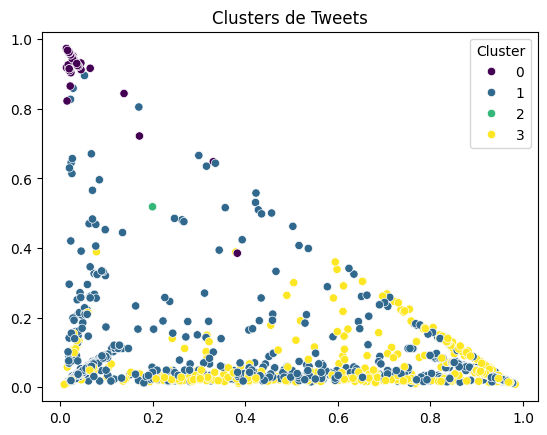

In [100]:

# Crear un modelo LDA (Latent Dirichlet Allocation)
lda = LatentDirichletAllocation(n_components=3, random_state=42)

# Ajustar el modelo LDA a los datos
X_topics = lda.fit_transform(X)

# Obtener las palabras asociadas a cada tema
tema_palabras = vectorizer.get_feature_names_out()
for idx, tema in enumerate(lda.components_):
    print(f"Tema {idx}:")
    print([tema_palabras[i] for i in tema.argsort()[:-10 - 1:-1]])

# Clustering con K-means
kmeans = KMeans(n_clusters=4, random_state=42)

# Asignar las etiquetas de cluster a los datos
df['Cluster'] = kmeans.fit_predict(X)

# Visualización de los Clusters
sns.scatterplot(x=X_topics[:, 0], y=X_topics[:, 1], hue=df['Cluster'], palette='viridis')
plt.title('Clusters de Tweets')
plt.show()


## Determinación del número óptimo de clusters usando el método del codo

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


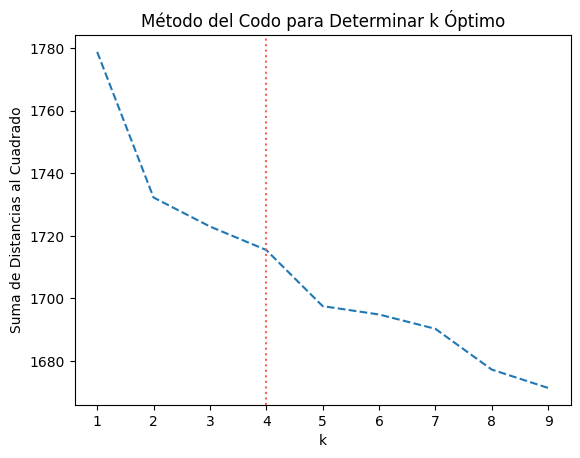

In [101]:
# Vectorización usando TF-IDF (Term Frequency-Inverse Document Frequency)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_copy['Embedded_text_Sumy'])

# Generar datos
K = range(1, 10)
Sum_of_squared_distances = []

# Calcular la suma de distancias al cuadrado para diferentes números de clusters
for k in K:
    km = KMeans(init="k-means++", n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

# Visualización del método del codo
ax = sns.lineplot(x=K, y=Sum_of_squared_distances)
ax.lines[0].set_linestyle("--")

# Añadir una línea vertical para mostrar el número óptimo de clusters
plt.axvline(4, color='#F26457', linestyle=':')

plt.xlabel('k')
plt.ylabel('Suma de Distancias al Cuadrado')
plt.title('Método del Codo para Determinar k Óptimo')
plt.show()

In [102]:
# Verificar si la columna 'clusters' existe en el DataFrame
if 'clusters' in df.columns:
    df.drop('clusters', axis=1, inplace=True)
else:
    print("La columna 'clusters' no existe en el DataFrame.")

# Definir el número de clusters basándose en la gráfica anterior
k = 4
# Vectorizar el texto usando TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_copy['Embedded_text_Sumy'])

# Inicializar y ajustar el modelo K-means
model = KMeans(init="k-means++", n_clusters=k, max_iter=25, n_init=1)
model.fit(X)

# Obtener las etiquetas de los clusters
clust_labels = model.predict(X)
cent = model.cluster_centers_

# Crear un DataFrame con las etiquetas de los clusters
kmeans_labels = pd.DataFrame(clust_labels)
df.insert((df.shape[1]),'clusters',kmeans_labels)

# Construir un DataFrame para mostrar las palabras clave de los clusters
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

results_dict = {}

for i in range(k):
    terms_list = []

    for ind in order_centroids[i, :15]:
        terms_list.append(terms[ind])

    results_dict[f'Cluster {i}'] = terms_list

df_clusters = pd.DataFrame.from_dict(results_dict)
df_clusters

La columna 'clusters' no existe en el DataFrame.


,Cluster 0,Cluster 1,Cluster 2,Cluster 3
0,no,respondiendo,atentos,davivienda
1,davivienda,dinero,privado,respuesta
2,respuesta,marianiniecheve,mensaje,wilsonariasc
3,daviplata,cuenta,quedamos,banco
4,solución,davivienda,caso,lugar
5,app,no,favor,equivocado
6,servicio,segurosbolivar,buenas,gracias
7,problema,edimejia,tardes,bancolombia
8,pasa,respuesta,respuesta,asnasalvaje
9,sirve,noticiasrcn,lamentamos,daviplata


In [103]:
df

,Unnamed: 0,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL,Cluster,clusters
0,0,Andrés Langebaek,@ALangebaek,2021-12-01T20:43:12.000Z,Andrés Langebaek\n@ALangebaek\n·\n1 dic.,La confianza se afectó. El indicador de confia...,NaN,1.0,7,19,['https://pbs.twimg.com/media/FFjL57eXMAISBnk?...,https://twitter.com/ALangebaek/status/14661458...,1,3
1,1,Plaza Futura,@plaza_futura,2021-12-01T21:18:10.000Z,Plaza Futura\n@plaza_futura\n·\n1 dic.,Buscamos la accesibilidad y mejor atención en ...,✅ ✅ ✅ ✅ ✅,NaN,NaN,NaN,['https://pbs.twimg.com/ext_tw_video_thumb/146...,https://twitter.com/plaza_futura/status/146615...,1,3
2,2,Julián Martinez,@JulianM998,2021-12-01T22:49:11.000Z,Julián Martinez\n@JulianM998\n·\n1 dic.,Señores \n@Davivienda\n no he podido ingresar ...,NaN,1.0,NaN,1,[],https://twitter.com/JulianM998/status/14661775...,3,0
3,3,Ferchis.,@fergomezr28,2021-12-01T12:29:07.000Z,Ferchis.\n@fergomezr28\n·\n1 dic.,Llevo toda una semana sufriendo intento de hur...,NaN,2.0,1,2,[],https://twitter.com/fergomezr28/status/1466021...,3,0
4,4,MirandaL2,@MirandaSuspLo,2021-12-01T20:52:36.000Z,MirandaL2\n@MirandaSuspLo\n·\n1 dic.,Hemos retrocedido tanto en este país con este ...,NaN,3.0,NaN,8,[],https://twitter.com/MirandaSuspLo/status/14661...,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1806,1806,Banco Davivienda,@Davivienda,2021-12-22T18:26:38.000Z,Banco Davivienda\n@Davivienda\n·\n22 dic.,En respuesta a \n@JaimeMolina\nBuenas tardes. ...,NaN,1.0,NaN,NaN,[],https://twitter.com/Davivienda/status/14737216...,0,2
1807,1807,Banco Davivienda,@Davivienda,2021-12-22T20:18:40.000Z,Banco Davivienda\n@Davivienda\n·\n22 dic.,"En respuesta a \n@josefe71\nHola Jose , gracia...",NaN,1.0,NaN,NaN,[],https://twitter.com/Davivienda/status/14737498...,0,2
1808,1808,Banco Davivienda,@Davivienda,2021-12-22T17:54:45.000Z,Banco Davivienda\n@Davivienda\n·\n22 dic.,En respuesta a \n@gleniiaaa\nHola! Bienvenida ...,👋,NaN,NaN,NaN,[],https://twitter.com/Davivienda/status/14737136...,0,3
1809,1809,Banco Davivienda,@Davivienda,2021-12-22T11:45:13.000Z,Banco Davivienda\n@Davivienda\n·\n22 dic.,"En respuesta a \n@diegoruix\nBuenos días, Sr. ...",NaN,NaN,NaN,NaN,[],https://twitter.com/Davivienda/status/14736206...,0,2


In [104]:
# Definir categorías para agrupación basándose en los resultados de la nube de palabras
categories = {
    "atencion al cliente": ["respuesta", "linea", "problema", "caso", "servicio", "solicitud", "ayuda", "atencion","hurto"],
    "soporte": ["app", "web", "acceso", "ingresar"],
    "marketing": ["comprar", "crédito", "cuenta", "beneficios"],
    "productos": ["daviplata", "corredores", "segurosbolivar", "cajero"]
}

['atencion al cliente', 'soporte', 'marketing', 'productos']
['respuesta', 'linea', 'problema', 'caso', 'servicio', 'solicitud', 'ayuda', 'atencion', 'hurto']
respuesta
linea
problema
caso
servicio
solicitud
ayuda
atencion
hurto
['app', 'web', 'acceso', 'ingresar']
app
web
acceso
ingresar
['comprar', 'crédito', 'cuenta', 'beneficios']
comprar
crédito
cuenta
beneficios
['daviplata', 'corredores', 'segurosbolivar', 'cajero']
daviplata
corredores
segurosbolivar
cajero
{'atencion al cliente': 4, 'soporte': 56, 'marketing': 6, 'productos': 134}


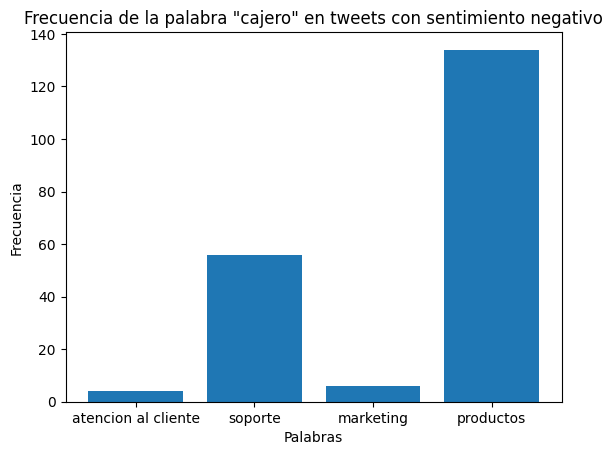

In [105]:

# Cargar el archivo CSV en un DataFrame
df = pd.read_csv(file_path)

# Filtrar el DataFrame para incluir solo las filas donde la columna 'Embedded_text_blob' es menor que 0.5
df_filtered = df_copy[df_copy['Embedded_text_blob'] < 0.5]

# Definir las categorías de palabras clave
keywords = list(categories.keys())
print(keywords)
dic2={}
for i in keywords:
  count=0
  print(categories[i])
  for j in categories[i]:
    print(j)
    total = df_filtered['Embedded_text'].str.contains(j).sum()
    count=total+total
  dic2[i]=count
print(dic2)


# Crear un gráfico de barras para mostrar la frecuencia de la palabra "cajero" en tweets con sentimiento negativo
plt.bar(dic2.keys(),dic2.values())
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de la palabra "cajero" en tweets con sentimiento negativo')
plt.show()


In [106]:
# Crear un objeto CountVectorizer para convertir datos de texto en vectores numéricos
vectorizer = CountVectorizer()

# Ajustar el vectorizador a la columna 'Embedded_text' del DataFrame df_copy
X = vectorizer.fit_transform(df_copy['Embedded_text'])

# Crear un objeto KMeans con 3 clusters
kmeans = KMeans(n_clusters=3)

# Ajustar el algoritmo de clustering KMeans a los datos vectorizados
kmeans.fit(X)

# Obtener las etiquetas de los clusters asignadas por KMeans
cluster_labels = kmeans.labels_

# Agregar las etiquetas de los clusters como una nueva columna 'Cluster' en el DataFrame df_copy
df_copy['Cluster'] = cluster_labels

# Encontrar e imprimir las palabras más representativas de cada cluster
for i in range(kmeans.n_clusters):
    palabras_cluster = []
    # Obtener los índices de las 10 palabras principales más representativas del cluster
    for j in kmeans.cluster_centers_[i].argsort()[:-10 - 1:-1]:
        palabras_cluster.append(vectorizer.get_feature_names_out()[j])
    print(f"Cluster {i}: {palabras_cluster}")


Cluster 0: ['respuesta', 'mensaje', 'atentos', 'privado', 'quedamos', 'caso', 'favor', 'buenas', 'tardes', 'gusto']
Cluster 1: ['no', 'davivienda', 'respuesta', 'daviplata', 'dinero', 'solución', 'problema', 'cuenta', 'sfcsupervisor', 'hacer']
Cluster 2: ['davivienda', 'respuesta', 'no', 'banco', 'cuenta', 'respondiendo', 'daviplata', 'bancolombia', 'wilsonariasc', 'app']


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [107]:
def summarize_to_one_word(sentence):
    """
    Resume una frase a su palabra más común después de procesarla.

    Parámetros:
    sentence (str): La frase de entrada que se va a resumir.

    Retorna:
    str: La palabra más común en la frase después del procesamiento.
    """
    # Tokenizar la frase
    palabras = word_tokenize(sentence.lower())

    # Eliminar puntuación
    palabras = [palabra for palabra in palabras if palabra.isalnum()]

    # Eliminar palabras vacías
    stop_words = set(stopwords.words('spanish'))
    palabras_filtradas = [palabra for palabra in palabras if palabra not in stop_words]

    # Distribución de frecuencias
    conteo_palabras = Counter(palabras_filtradas)

    # Obtener la palabra más común
    if conteo_palabras:
        palabra_mas_comun = conteo_palabras.most_common(1)[0][0]
    else:
        palabra_mas_comun = ""

    return palabra_mas_comun

# Ejemplo de uso
frase = "El rápido zorro marrón salta sobre el perro perezoso."
palabra_resumen = summarize_to_one_word(frase)
print(f"La palabra resumen es: {palabra_resumen}")


La palabra resumen es: rápido


In [108]:

# Crear un objeto TfidfVectorizer
vectorizer = TfidfVectorizer()

# Ajustar el vectorizador a la columna Embedded_text
X = vectorizer.fit_transform(df_copy['Embedded_text'])

# Obtener los vectores de palabras para las dos palabras
word1_vector = vectorizer.transform([df_copy['Embedded_text'][0]])
word2_vector = vectorizer.transform([df_copy['Embedded_text'][1]])

# Calcular la similitud coseno entre los dos vectores de palabras
similarity = cosine_similarity(word1_vector, word2_vector)[0][0]

# Imprimir el puntaje de similitud
print(f"Similitud entre {df_copy['Embedded_text'][0]} y {df_copy['Embedded_text'][1]}: {similarity}")



Similitud entre confianza afectó indicador confianza davivienda leve caída noviembre rompiendo tendencia cinco meses mejoras indicador deterioró especialmente última semana mes asociado aumento tasa cambio y buscamos accesibilidad mejor atención trámites bancarios ello encuentras plaza siguientes bancos preferencia banco cuscatlán banco fedecrédito davivienda bancoagrícola banco promerica: 0.001412565096689274


In [109]:


def preprocess_text(text):
    """
    Preprocesa un texto dividiéndolo en oraciones, tokenizando palabras, y eliminando puntuación y stopwords.

    Parámetros:
    text (str): El texto a procesar.

    Retorna:
    list: Una lista de listas de tokens limpios para cada oración.
    """
    # Tokenizar las oraciones
    sentences = sent_tokenize(text)

    # Tokenizar palabras en cada oración
    word_tokens = [word_tokenize(sentence.lower()) for sentence in sentences]

    # Eliminar puntuación y stopwords
    stop_words = set(stopwords.words('spanish'))
    cleaned_tokens = [[word for word in sentence if word.isalnum() and word not in stop_words]
                      for sentence in word_tokens]

    return cleaned_tokens

def train_word2vec_model(tokens):
    """
    Entrena un modelo Word2Vec sobre los tokens proporcionados.

    Parámetros:
    tokens (list): Lista de listas de tokens para entrenar el modelo.

    Retorna:
    Word2Vec: El modelo Word2Vec entrenado.
    """
    # Entrenar el modelo Word2Vec
    model = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=1, workers=4)
    return model

def word_similarity(model, word1, word2):
    """
    Calcula la similitud entre dos palabras usando un modelo Word2Vec.

    Parámetros:
    model (Word2Vec): El modelo Word2Vec entrenado.
    word1 (str): Primera palabra.
    word2 (str): Segunda palabra.

    Retorna:
    float or None: El puntaje de similitud coseno entre las dos palabras, o None si alguna palabra no está en el vocabulario.
    """
    # Calcular la similitud entre las dos palabras
    if word1 in model.wv and word2 in model.wv:
        return model.wv.similarity(word1, word2)
    else:
        return None



In [110]:
df_copy = df.copy()  # Copia del DataFrame original para mantenerlo intacto
df_copy["Embedded_text"] = df_copy["Embedded_text"].apply(f_preprocess_df)  # Aplicar la función de preprocesamiento a una copia del DataFrame
df_copy.drop(columns=['UserScreenName','UserName','Text','Timestamp','Unnamed: 0','Emojis','Comments','Likes','Retweets','Image link','Tweet URL'], inplace=True)


In [111]:
text = ''
for i in df_copy['Embedded_text']:
    text = text + i
print(text)

# Preprocesar el texto
tokens = preprocess_text(text)

# Entrenar el modelo Word2Vec
model = train_word2vec_model(tokens)

# Medir la similitud entre palabras
word1 = "cuenta"
word2 = "banco"
similarity = word_similarity(model, word1, word2)


la confianza se afectó el indicador de confianza davivienda tuvo una leve caída en noviembre rompiendo una tendencia de cinco meses de mejoras el indicador se deterioró especialmente en la última semana del mes asociado al aumento en la tasa de cambio buscamos la accesibilidad mejor atención en tus trámites bancarios es por ello que encuentras en nuestra plaza los siguientes bancos para tu preferencia banco cuscatlán banco fedecrédito davivienda bancoagrícola banco promericaseñores davivienda no he podido ingresar mi app davivienda ingreso la cédula me dice verifique los datos llevo así varios días llevo toda una semana sufriendo intento de hurto por medios electrónicos mi cuenta de ahorros davivienda sin que se puedan realizar porque no tengo plata no felices lo hicieron con la tc con esta sí pudieron ya que tenía cupo libre qué está pasando davivienda hemos retrocedido tanto en este país con este gobierno que hasta los malparidos cajeros de davivienda dizque solo botan de pesos en bi

In [112]:
if similarity is not None:
    print(f"The similarity between '{word1}' and '{word2}' is: {similarity}")
else:
    print(f"One or both words not in vocabulary.")

The similarity between 'cuenta' and 'banco' is: 0.8097454309463501


In [113]:
for i in df_copy['Embedded_text']:
    a = preprocess_text(i)
    b = train_word2vec_model(a)

    word1 = "daviplata"
    word2 = "davivienda"
    similarity = word_similarity(b, word1, word2)
    if similarity is not None:
        print(f"La similitud entre '{word1}' y '{word2}' es: {similarity}")
    else:
        print(f"Una o ambas palabras no están en el vocabulario.")

word1 = "daviplata"
word2 = "confianza"
similarity = word_similarity(b, word1, word2)
if similarity is not None:
    print(f"La similitud entre '{word1}' y '{word2}' es: {similarity}")
else:
    print(f"Una o ambas palabras no están en el vocabulario.")


Una o ambas palabras no están en el vocabulario.
Una o ambas palabras no están en el vocabulario.
Una o ambas palabras no están en el vocabulario.
Una o ambas palabras no están en el vocabulario.
Una o ambas palabras no están en el vocabulario.
La similitud entre 'daviplata' y 'davivienda' es: 0.004701696801930666
Una o ambas palabras no están en el vocabulario.
Una o ambas palabras no están en el vocabulario.
La similitud entre 'daviplata' y 'davivienda' es: 0.08029685169458389
Una o ambas palabras no están en el vocabulario.
Una o ambas palabras no están en el vocabulario.
Una o ambas palabras no están en el vocabulario.
La similitud entre 'daviplata' y 'davivienda' es: 0.03476493060588837
Una o ambas palabras no están en el vocabulario.
Una o ambas palabras no están en el vocabulario.
Una o ambas palabras no están en el vocabulario.
Una o ambas palabras no están en el vocabulario.
Una o ambas palabras no están en el vocabulario.
Una o ambas palabras no están en el vocabulario.
Una o

In [114]:
#implementar pca?

In [115]:
df_copy['Embedded_text'].head()

0    la confianza se afectó el indicador de confian...
1    buscamos la accesibilidad mejor atención en tu...
2    señores davivienda no he podido ingresar mi ap...
3    llevo toda una semana sufriendo intento de hur...
4    hemos retrocedido tanto en este país con este ...
Name: Embedded_text, dtype: object

In [116]:
e=''

# Train Word2Vec mo

# Measure similarity between words
word1 = "banco"
word2 = "davivienda"
similarity = word_similarity(model, word1, word2)

if similarity is not None:
    print(f"The similarity between '{word1}' and '{word2}' is: {similarity}")
else:
    print(f"One or both words not in vocabulary.")

The similarity between 'banco' and 'davivienda' is: 0.9368224143981934
